# Compute Dataset Stats

**Author:** Prisca Dotti

**Last modified:** 02/04/2024

Used this script for the following purposes:
- Compute number of individual instances per type
- Analyze type of noise present in movies
- ...


In [12]:
# autoreload is used to reload modules automatically before entering the
# execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2
# To import modules from parent directory in Jupyter Notebook
import sys

sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
import logging
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import Normalize
from scipy.fft import fft2, fftshift
from scipy.signal import find_peaks
from skimage import morphology, exposure
from typing import Dict, List, Any

from config import TrainingConfig, config
from data.data_processing_tools import (
    get_cell_mask,
    masks_to_instances_dict,
    remove_background,
)
from data.datasets import SparkDataset
from utils.training_script_utils import init_dataset
from utils.visualization_tools import add_scale_bar

# Setup logging
logging.basicConfig(level=logging.INFO)



logging.getLogger("matplotlib").setLevel(
    logging.WARNING
)  # Or use logging.ERROR to see only errors
logger = logging.getLogger(__name__)



config.verbosity = 3  # To get debug messages

In [14]:
############################ Get default parameters ############################

dataset_ids = [
    "01",
    "02",
    "03",
    "04",
    "05",
    "06",
    "07",
    "08",
    "09",
    "10",
    "11",
    "12",
    "13",
    "14",
    "15",
    "16",
    "17",
    "18",
    "19",
    "20",
    "21",
    "22",
    "23",
    "24",
    "25",
    "27",
    "28",
    "29",
    "30",
    "32",
    "33",
    "34",
    "35",
    "36",
    "38",
    "39",
    "40",
    "41",
    "42",
    "43",
    "44",
    "45",
    "46",
]
# sample_ids = dataset_ids
sample_ids = ["01", "05", "34"]

# Initialize general parameters with default values
params = TrainingConfig()

In [15]:
fps_values = [
    138.8,
    147.5,
    147.5,
    147.5,
    139.7,
    137.6,
    137.5,
    147.5,
    137.3,
    138.1,
    137.8,
    147.5,
    147.5,
    147.5,
    147.5,
    147.5,
    147.5,
    147.5,
    147.5,
    147.5,
    147.5,
    147.5,
    147.5,
    147.5,
    147.5,
    147.5,
    147.5,
    147.5,
    147.5,
    147.5,
    169.5,
    169.5,
    169.5,
    169.5,
    150.0,
    150.0,
    150.0,
    150.0,
    150.0,
    150.0,
    150.0,
    150.0,
    150.0,
]
fps_dict = dict(zip(dataset_ids, fps_values))

In [55]:
############################## Configure dataset ###############################

logger.info(f"Loading samples {sample_ids}.")
logger.info(f"Using {params.dataset_dir} as dataset root path.")

# Create dataset
dataset = init_dataset(
    params=params,
    sample_ids=sample_ids,
    apply_data_augmentation=False,
    print_dataset_info=True,
    load_instances=True,
)

INFO:__main__:Loading samples ['01', '05', '34'].
INFO:__main__:Using C:\Users\prisc\Code\sparks_project\data\sparks_dataset as dataset root path.
INFO:utils.training_script_utils:Samples in dataset: 40


### Analyze number of events in movies

In [ ]:
instances = dataset.get_instances()
labels = dataset.get_labels()

In [ ]:
# Compute the number of instances per class per movie
n_instances_per_movie = {movie_id: {} for movie_id in sample_ids}

for movie_id, i, l in zip(sample_ids, instances.values(), labels.values()):
    movie_instances_dict = masks_to_instances_dict(i, l)

    n_instances_per_type = {
        c: len(np.unique(i)) - 1 for c, i in movie_instances_dict.items()
    }
    n_instances_per_movie[movie_id] = n_instances_per_type

In [ ]:
# Convert nested dictionary into a DataFrame for easier analysis
instances_df = pd.DataFrame.from_dict(n_instances_per_movie, orient="index")

# Calculate total number of each event type across all movies
total_events = instances_df.sum()

# Calculate average number of each event type per movie
average_events = instances_df.mean()

# Find the movie with the maximum number of each event type
max_events = instances_df.idxmax()

# Gather statistics in a dictionary for easier presentation
stats = {
    "total_sparks": total_events["sparks"],
    "total_waves": total_events["waves"],
    "total_puffs": total_events["puffs"],
    "average_sparks": average_events["sparks"],
    "average_waves": average_events["waves"],
    "average_puffs": average_events["puffs"],
    "movie_most_sparks": (
        max_events["sparks"],
        instances_df.loc[max_events["sparks"]]["sparks"],
    ),
    "movie_most_waves": (
        max_events["waves"],
        instances_df.loc[max_events["waves"]]["waves"],
    ),
    "movie_most_puffs": (
        max_events["puffs"],
        instances_df.loc[max_events["puffs"]]["puffs"],
    ),
    "total_instances": instances_df.sum(axis=1).sum(),  # Total of all instances
}

stats

{'total_sparks': 110,
 'total_waves': 6,
 'total_puffs': 35,
 'average_sparks': 36.666666666666664,
 'average_waves': 2.0,
 'average_puffs': 11.666666666666666,
 'movie_most_sparks': ('05', 71),
 'movie_most_waves': ('34', 6),
 'movie_most_puffs': ('05', 26),
 'total_instances': 151}

In [ ]:
instances_df

,sparks,waves,puffs
01,23,0,6
05,71,0,26
34,16,6,3


In [ ]:
# Convert the DataFrame to a binary DataFrame where 1 indicates the presence of an event
movies_with_events = (instances_df > 0).astype(int)

# Sum each column to get the number of movies that contain each event type
n_movies_with_events = movies_with_events.sum()

# Output the results
for event_type, n_movies in n_movies_with_events.items():
    print(f"Number of movies with {event_type}: {n_movies}")

Number of movies with sparks: 3
Number of movies with waves: 1
Number of movies with puffs: 3


In [ ]:
# Initialize dictionaries to count the number of each event type in the test and train datasets
train_event_counts = {"sparks": 0, "waves": 0, "puffs": 0}
test_event_counts = {"sparks": 0, "waves": 0, "puffs": 0}

# Iterate over the nested dictionary to sum the events for each dataset
for movie_id, events in n_instances_per_movie.items():
    if movie_id in train_ids:
        for event, count in events.items():
            train_event_counts[event] += count
    elif movie_id in test_ids:
        for event, count in events.items():
            test_event_counts[event] += count

train_event_counts, test_event_counts

({'sparks': 23, 'waves': 0, 'puffs': 6},
 {'sparks': 87, 'waves': 6, 'puffs': 29})

In [ ]:
# Now we have the total counts for each event type in the train and test datasets
# Calculate the ratios of each event type in the train dataset vs. the test dataset
ratios = {}
for event_type in train_event_counts.keys():
    if test_event_counts[event_type] > 0:  # To avoid division by zero
        ratios[event_type] = (
            train_event_counts[event_type] / test_event_counts[event_type]
        )
    else:
        ratios[event_type] = float(
            "inf"
        )  # If the event type is not present in the test dataset at all

# Given the ratios, convert them to percentages
percentages = {}
for event_type in train_event_counts.keys():
    percentages[event_type] = (
        100
        * test_event_counts[event_type]
        / (train_event_counts[event_type] + test_event_counts[event_type])
    )

percentages

{'sparks': 79.0909090909091, 'waves': 100.0, 'puffs': 82.85714285714286}

### Analyze type of noise in samples

#### Methods

In [123]:
def plot_sample_frames(frames_list, magnitude_spectrum_list, titles, figsize=(16, 8)):
    fig, axs = plt.subplots(
        3, len(frames_list), figsize=figsize, gridspec_kw={"height_ratios": [1, 2, 1]}
    )
    for i, frame in enumerate(frames_list):
        # Plot the frames
        axs[0, i].imshow(frame, cmap="gray")
        axs[0, i].set_title(titles[i])
        axs[0, i].axis("off")
        # Add a scale bar of 10 micrometers at the bottom right with a height of 1 micrometer
        if i == 0:
            add_scale_bar(
                axs[0, i],
                pixel_size=0.2,
                bar_length_um=10,
                bar_height_um=0.4,
                bar_color="crimson",
                bar_location=(frame.shape[1] - 60, frame.shape[0] - 7),
                text_location=(frame.shape[1] - 10, frame.shape[0] - 10),
            )
        # Plot histograms using Seaborn
        sns.histplot(frame.ravel(), bins=256, kde=False, ax=axs[1, i])
        # axs[1, i].hist(frame.ravel(), bins=256, color="gray", alpha=0.7)
        axs[1, i].set_title(f"Pixel Intensity Histogram")
        axs[1, i].set_xlabel("Pixel Intensity")
        axs[1, i].set_ylabel("Count")
        magnitude_spectrum = 20 * np.log(magnitude_spectrum_list[i])
        axs[2, i].imshow(magnitude_spectrum, cmap="gray")
        axs[2, i].set_title(f"Magnitude Spectrum")
        axs[2, i].axis("off")

    plt.subplots_adjust(
        left=0.1, right=0.8, top=0.9, bottom=0.1, wspace=0.2, hspace=0.0
    )

    plt.tight_layout()
    plt.show()


from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec


def plot_sample_temporal_profiles(
    movie,
    cell_mask,
    roi_mean,
    temporal_std,
    magnitude_spectrum,
    fps,
    titles: List[str],
    figsize=(16, 8),
):
    # Create a grid layout for the figure
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1.05], height_ratios=[1, 2])

    # Use GridSpec to create the subplots
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    ax3 = fig.add_subplot(gs[2])
    ax4 = fig.add_subplot(gs[3])

    # # Use an equalized colormap to improve contrast in the images
    # colormap = plt.cm.viridis

    # Plot cell and contour
    mean_frame = np.mean(movie, axis=0)
    equalized_mean_frame = exposure.equalize_adapthist(mean_frame)
    ax1.imshow(equalized_mean_frame, cmap="gray")
    ax1.contour(cell_mask, colors="blue", alpha=0.3)
    ax1.axis("off")
    add_scale_bar(
        ax1,
        pixel_size=0.2,
        bar_length_um=10,
        bar_height_um=0.4,
        bar_color="white",
        bar_location=(movie.shape[2] - 60, movie.shape[1] - 7),
        text_location=(movie.shape[2] - 10, movie.shape[1] - 10),
    )
    ax1.set_title(titles[0])

    # Display the temporal standard deviation map
    norm = Normalize(vmin=temporal_std.min(), vmax=temporal_std.max())
    im = ax2.imshow(temporal_std, cmap="hot", norm=norm)
    ax2.contour(cell_mask, colors="blue", alpha=0.3)
    ax2.axis("off")
    ax2.set_title(titles[2])  # , pad=20)

    # Create an axis for the colorbar
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", pad=0.1, size="1%")
    cbar = plt.colorbar(im, cax=cax, orientation="vertical", shrink=0.5)
    # cax.xaxis.set_ticks_position('top')
    cbar.set_ticks([np.min(temporal_std), np.max(temporal_std)])
    cbar.ax.yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, pos: "{:0.2f}".format(x))
    )

    # Plot temporal profile
    # Use ms in x axis instead of frames
    x_axis = np.arange(len(roi_mean)) / fps * 1000
    sns.lineplot(ax=ax3, x=x_axis, y=roi_mean, color="royalblue")
    ax3.set_title(titles[1])
    ax3.set_xlabel("Time [ms]")
    ax3.set_ylabel("Mean Intensity [AU]")
    ax3.set_xlim(0, len(roi_mean) / fps * 1000)

    # Plot the mean magnitude spectrum to see the temporal frequency content
    sns.lineplot(
        ax=ax4,
        x=range(len(magnitude_spectrum)),
        y=magnitude_spectrum,
        color="royalblue",
    )
    ax4.set_title(titles[3])
    ax4.set_xlabel("Frequency Index")
    ax4.set_ylabel("Magnitude")
    ax4.set_xlim(0, len(magnitude_spectrum))
    ax4.set_ylim(min(magnitude_spectrum) * 0.9, np.percentile(magnitude_spectrum, 98))

    fig.tight_layout()
    plt.subplots_adjust(
        left=0.1, right=0.8, top=0.9, bottom=0.1, wspace=0.2, hspace=0.05
    )

    # # Manually adjust the axes to have the same size
    # pos1 = ax1.get_position()  # get the original position
    # pos2 = ax2.get_position()
    # ax2.set_position([pos2.x0, pos1.y0, pos1.width, pos1.height])

    plt.show()

In [106]:
def analyze_spatial_noise(
    sample_ids: List[str],
    dataset: SparkDataset,
) -> None:
    movies = dataset.get_movies()

    for sample_id in sample_ids:
        print(f"Analyzing spatial noise for sample {sample_id}")
        idx = sample_ids.index(sample_id)
        movie_original = movies[idx]

        # Calculate basic statistics for a rough analysis of noise and image characteristics
        mean_intensity = np.mean(movie_original)
        std_intensity = np.std(movie_original)
        max_intensity = np.max(movie_original)
        min_intensity = np.min(movie_original)

        # Display basic statistics
        print(f"\tMean intensity: {mean_intensity}")
        print(f"\tStandard deviation of intensity: {std_intensity}")
        print(f"\tMaximum intensity: {max_intensity}")
        print(f"\tMinimum intensity: {min_intensity}")

        # Remove background from the movie (offline background subtraction)
        movie = remove_background(movie_original, mode="offline")

        # Compute Fourier Transform on few sample frames
        T = movie_original.shape[0]
        frames_to_inspect = [0, T // 2, T - 1]
        magniture_spectrums = []

        for frame_id in frames_to_inspect:
            frame = movie[frame_id]

            # Compute the 2D Fourier transform of the image
            f_transform = np.array(fft2(frame))

            # Shift the zero frequency component to the center of the spectrum
            f_transform_centered = fftshift(f_transform)

            # Compute the magnitude spectrum of the Fourier transform
            magnitude_spectrum = np.abs(f_transform_centered)
            magniture_spectrums.append(magnitude_spectrum)

        plot_sample_frames(
            frames_list=movie[frames_to_inspect],
            magnitude_spectrum_list=magniture_spectrums,
            titles=[
                "First Frame (No Background)",
                "Middle Frame (No Background)",
                "Last Frame (No Background)",
            ],
            # figsize=(15, 10),
        )

        # Apply spatial filtering to the movie
        # movie_filtered = np.zeros_like(movie)

        # TODO


def analyze_temporal_noise(
    sample_ids: List[str],
    dataset: SparkDataset,
    fps: Dict[str, Any],
) -> None:
    movies = dataset.get_movies()

    for sample_id in sample_ids:
        print(f"Analyzing temporal noise for sample {sample_id}")
        idx = sample_ids.index(sample_id)
        movie_original = movies[idx]
        T, H, W = movie_original.shape
        movie_fps = fps[sample_id]

        # Remove background from the movie (offline background subtraction)
        movie = remove_background(movie_original, mode="offline")

        # Select ROI for temporal analysis as mean of the exterior of the cell
        cell_mask = get_cell_mask(movie_original)
        dilated_mask = morphology.binary_dilation(cell_mask, morphology.disk(10))
        roi = movie_original[:, ~dilated_mask]
        roi_mean = np.mean(roi, axis=1)

        # Compute difference between consecutive frames for the entire movie
        diff_movie = np.diff(movie, axis=0)

        # # Calculate temporal standard deviation for each pixel
        # temporal_std = np.std(movie, axis=0)

        # Calculate the standard deviation across the differential movie
        temporal_diff_std = np.std(diff_movie, axis=0)

        # Apply the Fourier transform along the time axis
        f_transform = np.fft.fft(movie_original, axis=0)

        # Compute the magnitude spectrum, which is the absolute value of the complex spectrum
        magnitude_spectrum = np.abs(f_transform)

        # Compute the mean magnitude spectrum across all spatial locations
        half_index = T // 2
        mean_magnitude_spectrum = magnitude_spectrum[:half_index].mean(axis=(1, 2))
        # mean_magnitude_spectrum = magnitude_spectrum.mean(axis=(1, 2))

        plot_sample_temporal_profiles(
            movie=movie_original,
            cell_mask=dilated_mask,
            roi_mean=roi_mean,
            temporal_std=temporal_diff_std,
            magnitude_spectrum=mean_magnitude_spectrum,
            fps=movie_fps,
            titles=[
                "Mean Movie Frame with Cell Contour",
                "Background Temporal Profile",
                "Temporal Difference Standard Deviation",
                "Average Temporal Magnitude Spectrum (Low Frequencies)",
            ],
            # figsize=(8, 8),
        )

#### Main Code

##### Analyze spatial noise

Analyzing spatial noise for sample 01
	Mean intensity: 0.051760345697402954
	Standard deviation of intensity: 0.05946328863501549
	Maximum intensity: 0.5013383626937866
	Minimum intensity: 0.0


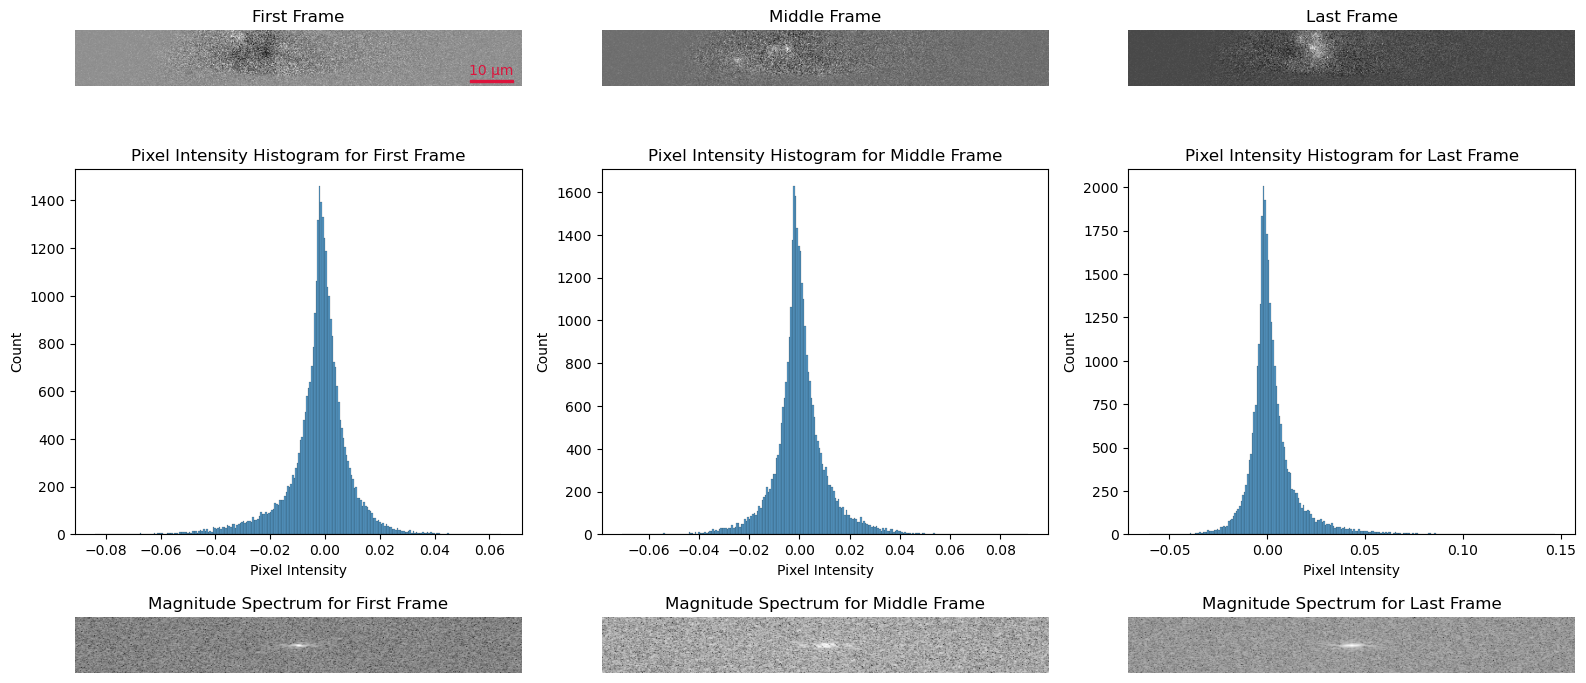

Analyzing spatial noise for sample 05
	Mean intensity: 0.09531935304403305
	Standard deviation of intensity: 0.09265033155679703
	Maximum intensity: 0.8667637705802917
	Minimum intensity: 0.0


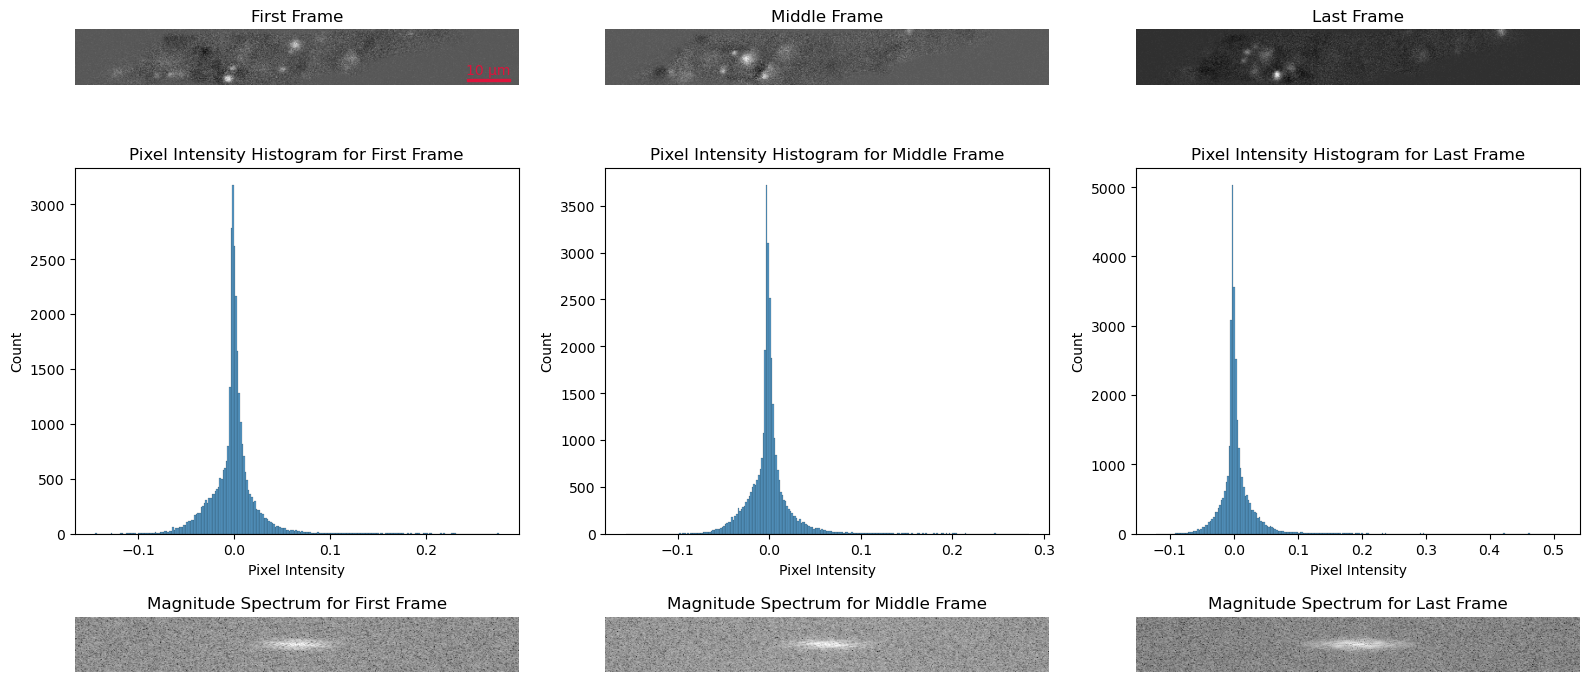

Analyzing spatial noise for sample 34
	Mean intensity: 0.02348945662379265
	Standard deviation of intensity: 0.02853160910308361
	Maximum intensity: 0.4648139178752899
	Minimum intensity: 0.0


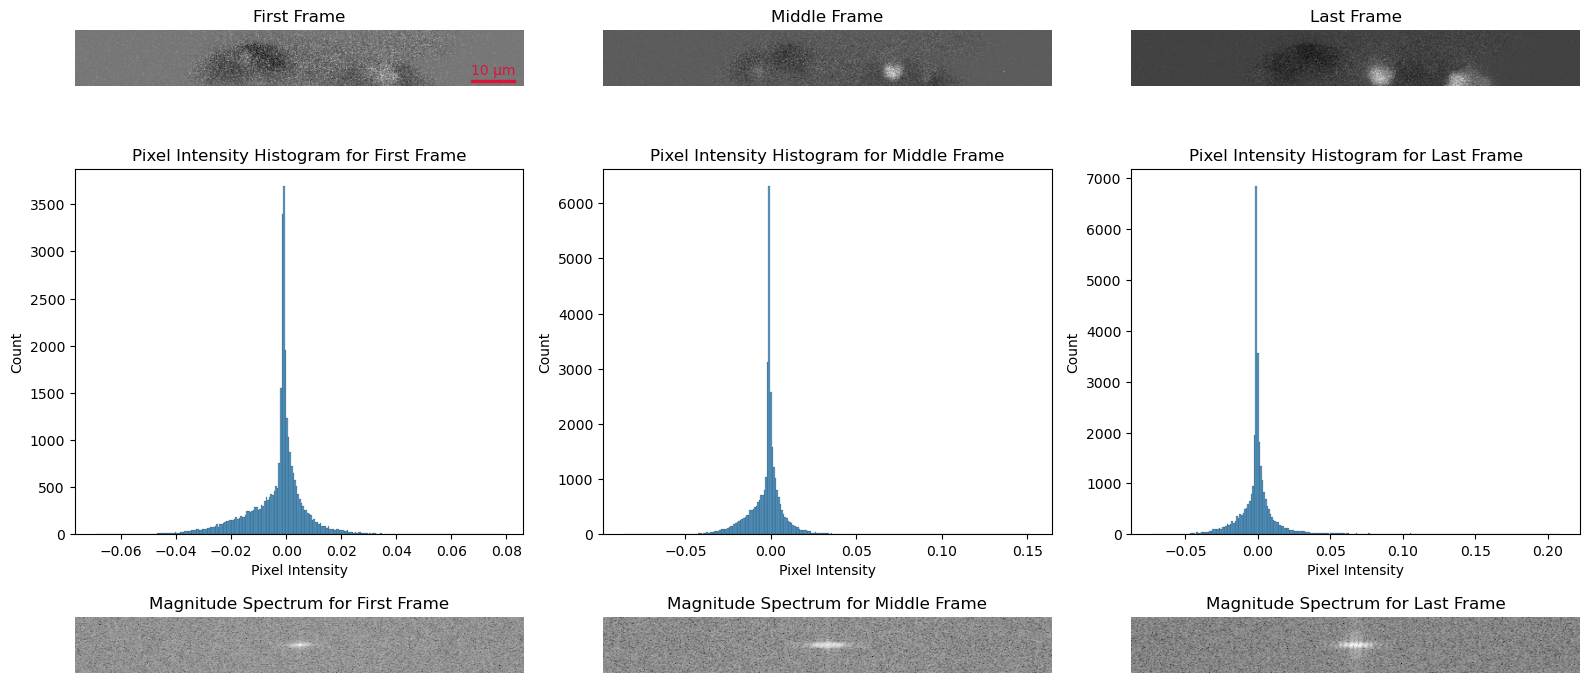

In [122]:
analyze_spatial_noise(sample_ids=sample_ids, dataset=dataset)

##### Analyze temporal noise

Analyzing temporal noise for sample 01


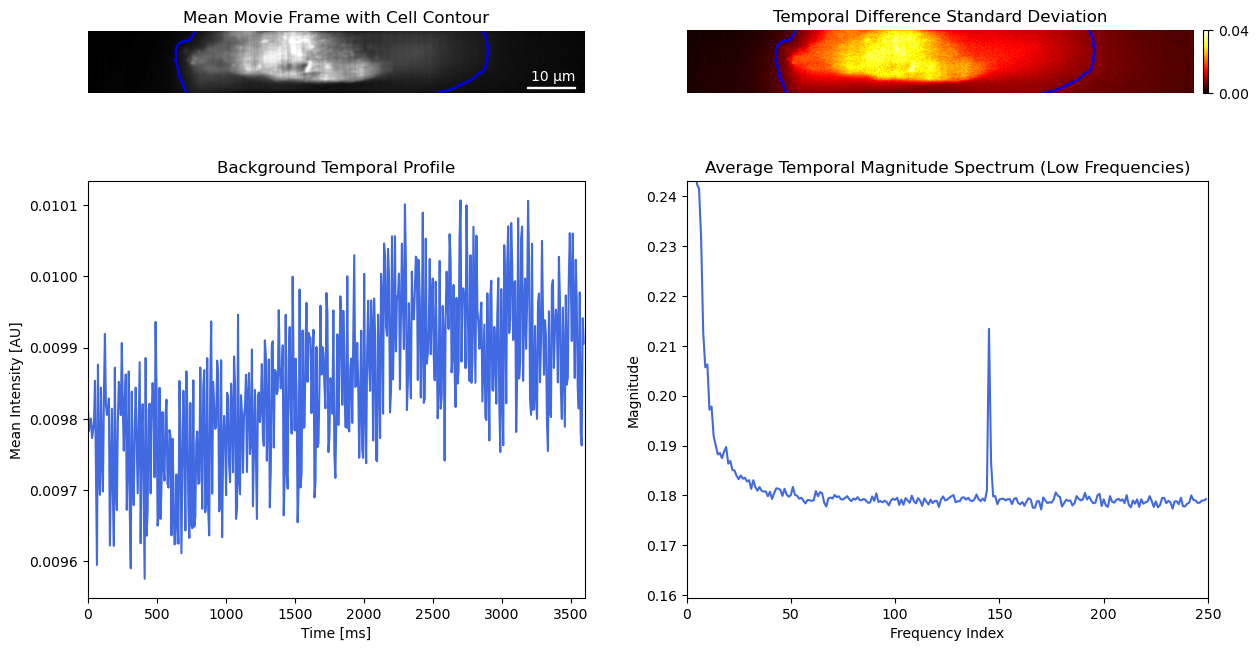

Analyzing temporal noise for sample 05


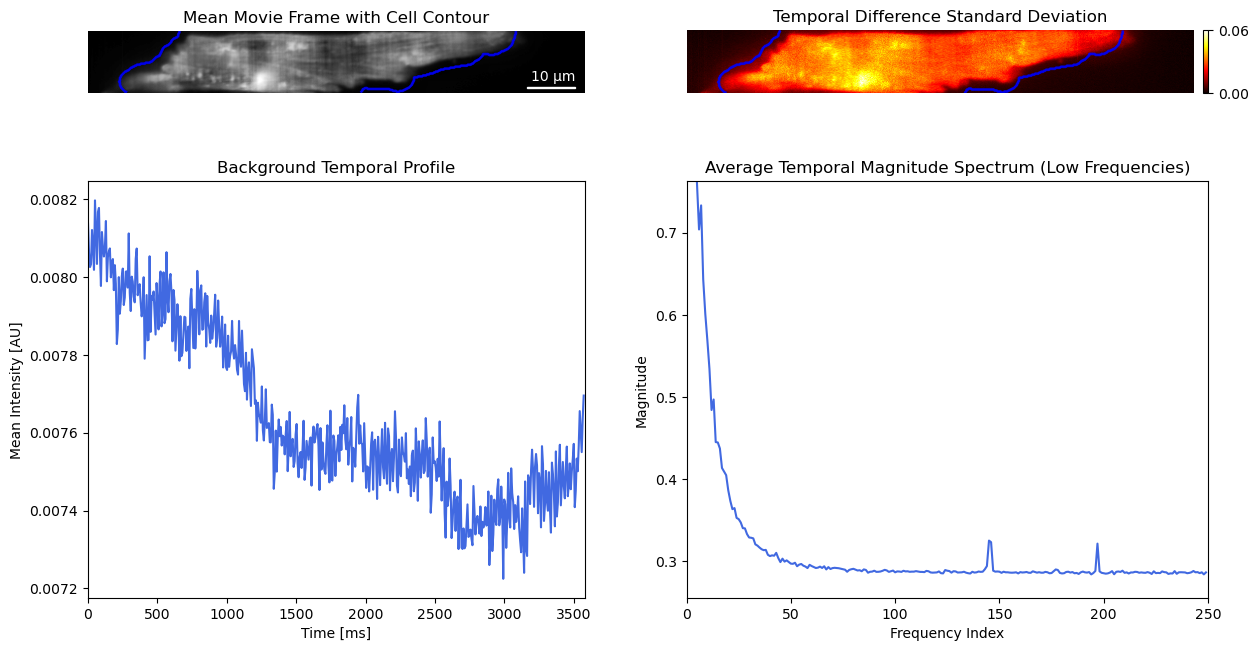

Analyzing temporal noise for sample 34


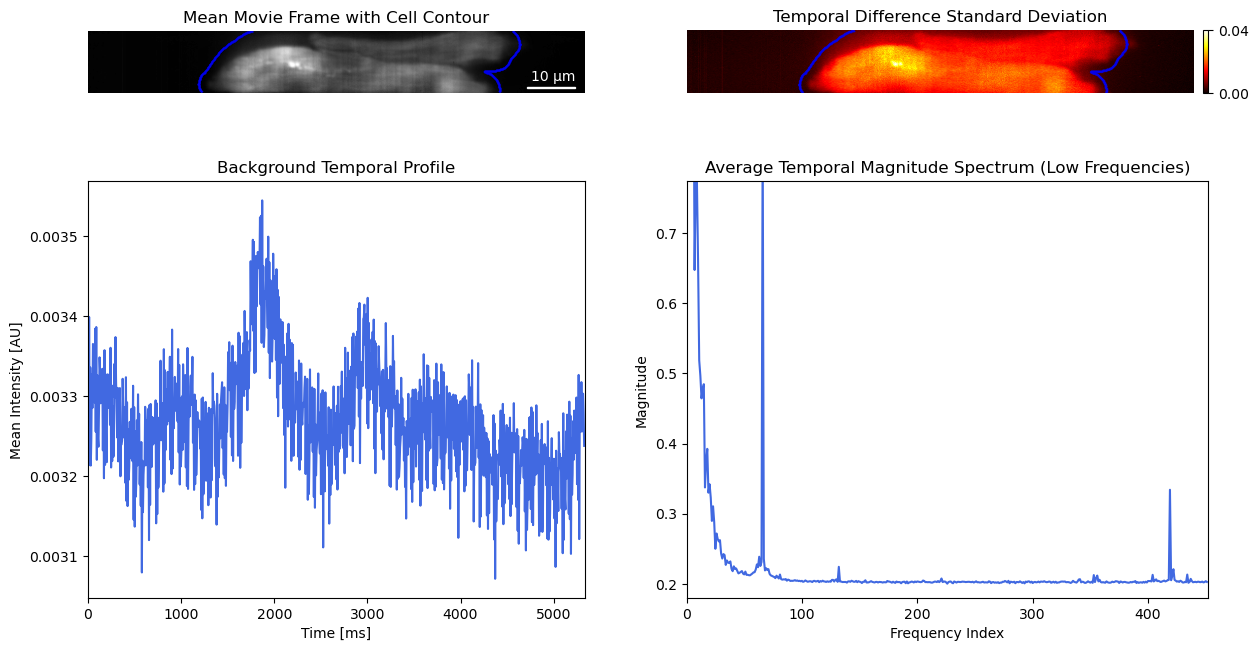

In [118]:
analyze_temporal_noise(sample_ids=sample_ids, dataset=dataset, fps=fps_dict)

In [97]:
# # Exclude the first few indices that represent the DC component
# excluded_indices = 25  # number of indices to exclude
# mean_magnitude_spectrum_excluded = mean_magnitude_spectrum[excluded_indices:half_index]

# # Define a threshold that is a certain number of standard deviations above the mean
# # of the remaining spectrum
# std_devs_above_mean = 1  # Empirically determined
# mean_val = np.mean(mean_magnitude_spectrum_excluded)
# std_dev_val = np.std(mean_magnitude_spectrum_excluded)
# height_threshold = mean_val + (std_devs_above_mean * std_dev_val)

# distance_between_peaks = 5  # Empirically determined

# peaks, properties = find_peaks(
#     mean_magnitude_spectrum_excluded,
#     height=height_threshold,
#     distance=distance_between_peaks,
# )
# peaks += excluded_indices  # Add the excluded indices back to the peak indices


# # Highlight the significant peaks
# plt.plot(peaks, mean_magnitude_spectrum[peaks], ".", color="red", alpha=0.5)
# plt.show()

# # Print out the significant peaks and their heights
# for i, peak in enumerate(peaks):
#     print(f"Peak at index {peak} with height {properties['peak_heights'][i]}")

# spike_id = 66  # Determined from plot above
# T = movie.shape[0]

# # get the value of fps_df such that the column movie is equal to movie_id[0]
# fps = fps_df.loc[fps_df["Movie"] == movie_id[0], "FPS"].values[0]
# # Calculate the frequency in Hz
# freq_in_hz = (spike_id / T) * fps

# print(f"The frequency of the movie is: {fps} Hz")
# print(f"The frequency of the spike is approximately: {freq_in_hz} Hz")